In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits

import torch
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split

os.chdir('BayesHI')
import bayeshi

In [2]:
model = bayeshi.load_model('tpcnet_all_phases')

/home/120/em8117/.local/lib/python3.12/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


In [3]:
spectra = fits.getdata('/scratch/mk27/em8117/R8_2pc/0300/300_Tb_full.fits')[:,1600:1950,:]
fcnm = fits.getdata('/scratch/mk27/em8117/R8_2pc/0300/300_fcnm_full.fits')[1600:1950,:]
funm = fits.getdata('/scratch/mk27/em8117/R8_2pc/0300/300_funm_full.fits')[1600:1950,:]
fwnm = fits.getdata('/scratch/mk27/em8117/R8_2pc/0300/300_fwnm_full.fits')[1600:1950,:]
rhi = fits.getdata('/scratch/mk27/em8117/R8_2pc/0300/300_rhi_full.fits')[1600:1950,:]

spectra += np.random.randn(*spectra.shape) * 0.5 # 0.5K of noise

fcnm = fcnm.flatten()
funm = funm.flatten()
fwnm = fwnm.flatten()
rhi = rhi.flatten()

spectra = np.moveaxis(spectra, 0, -1)
spectra = spectra.reshape(-1, spectra.shape[-1])

nanIndices = np.isnan(spectra).any(axis=1) | np.isnan(fcnm) | np.isnan(funm) | np.isnan(fwnm) | np.isnan(rhi) | np.all(spectra == 0, axis=1)
spectra = spectra[~nanIndices]
fcnm = fcnm[~nanIndices]
funm = funm[~nanIndices]
fwnm = fwnm[~nanIndices]
rhi = rhi[~nanIndices]
los_removed = np.sum(nanIndices)
print(f'Removed {los_removed} lines of sight with NaNs')

Removed 0 lines of sight with NaNs


In [4]:
targets = np.stack((fcnm,
                    funm,
                    fwnm,
                    rhi
                   ), axis=1) # Axis 1 because we want (x*z, 4)

In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(spectra, targets, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.1, random_state=42)

In [6]:
train_dataset = TensorDataset(torch.Tensor(X_train+0), torch.Tensor(y_train+0))
val_dataset = TensorDataset(torch.Tensor(X_val+0), torch.Tensor(y_val+0))
test_dataset = TensorDataset(torch.Tensor(X_test+0), torch.Tensor(y_test+0))

In [7]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256)
test_loader = DataLoader(test_dataset, batch_size=256)

Training Model
Initial learning rate: [0.0001]
Epoch 1: 100%|██████████| 490/490 [00:17<00:00, 28.71batch/s]
Epoch [1/128], Train Loss: 0.4170, Validation Loss: 0.0421, took 18.28s
Epoch 2: 100%|██████████| 490/490 [00:15<00:00, 31.87batch/s]
Epoch [2/128], Train Loss: 0.1355, Validation Loss: 0.0278, took 16.58s
Epoch 3: 100%|██████████| 490/490 [00:15<00:00, 31.56batch/s]
Epoch [3/128], Train Loss: 0.0984, Validation Loss: 0.0219, took 16.73s
Epoch 4: 100%|██████████| 490/490 [00:15<00:00, 31.87batch/s]
Epoch [4/128], Train Loss: 0.0805, Validation Loss: 0.0186, took 16.58s
Epoch 5: 100%|██████████| 490/490 [00:15<00:00, 31.85batch/s]
Epoch [5/128], Train Loss: 0.0695, Validation Loss: 0.0163, took 16.75s
Epoch 6: 100%|██████████| 490/490 [00:15<00:00, 31.90batch/s]
Epoch [6/128], Train Loss: 0.0620, Validation Loss: 0.0147, took 16.55s
Epoch 7: 100%|██████████| 490/490 [00:15<00:00, 31.94batch/s]
Epoch [7/128], Train Loss: 0.0565, Validation Loss: 0.0134, took 16.54s
Epoch 8: 100%|█

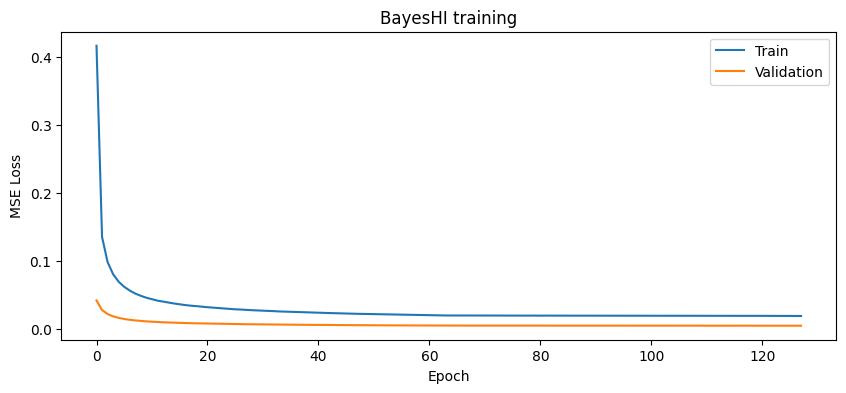

In [8]:
if os.path.exists('./checkpoints/tpcnet_newPE_training.pth'):
    model.load_weights('./checkpoints/tpcnet_newPE_training.pth')
else:
    train_errors, val_errors, *_ = model.fit(train_loader, val_loader, "./checkpoints/tpcnet_newPE_training.pth")
    plt.figure(figsize=(10,4))
    plt.plot(train_errors, label='Train')
    plt.plot(val_errors, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.title(f'BayesHI training')
    plt.show()

In [10]:
# Predict on test set
predictions = model.predict(test_loader, 1).cpu().numpy()

Predicting: 100%|██████████| 1/1 [00:00<00:00,  7.99it/s]


In [11]:
avg_predictions = predictions[0]

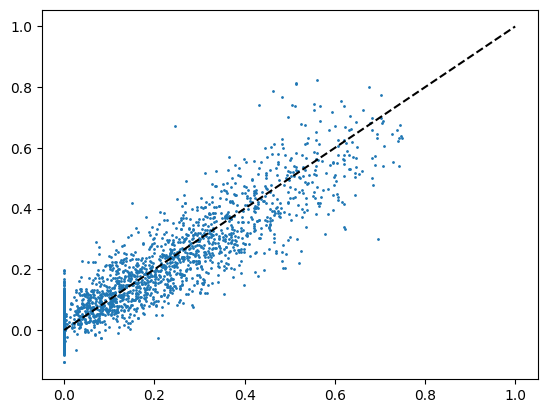

In [12]:
plt.scatter(y_test[:,0], avg_predictions[:,0], s=1)
plt.plot([0,1],[0,1],'k--')

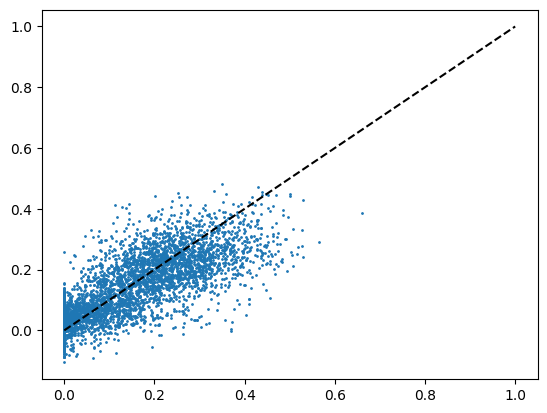

In [13]:
plt.scatter(y_test[:,1], avg_predictions[:,1], s=1)
plt.plot([0,1],[0,1],'k--')

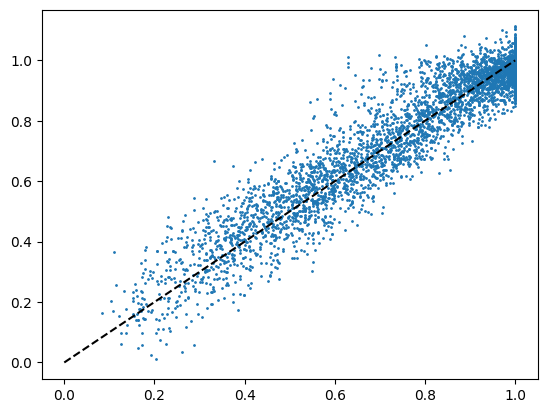

In [14]:
plt.scatter(y_test[:,2], avg_predictions[:,2], s=1)
plt.plot([0,1],[0,1],'k--')

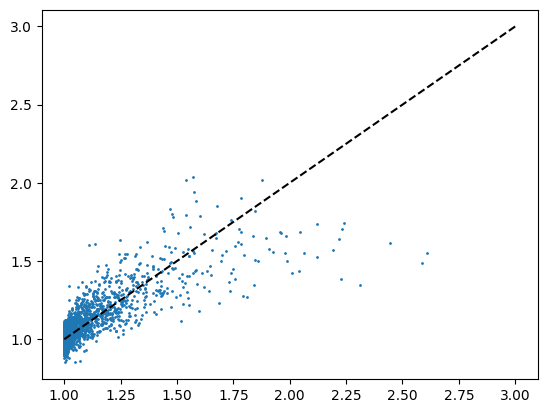

In [15]:
plt.scatter(y_test[:,3], avg_predictions[:,3], s=1)
plt.plot([1,3],[1,3],'k--')